In [1]:
import numpy as np
from matplotlib import pyplot as plt

def show_as_image(binary_image, figsize=(10, 5)):
    plt.figure(figsize=figsize)
    plt.imshow(binary_image, cmap='gray')
    plt.xticks([]); plt.yticks([])

%matplotlib inline

In [2]:
import torch
import torch.nn as nn
from torchvision import datasets, utils
from torch.autograd import Variable

## Pixel CNN

Alternative to Pixel RNN from [Pixel Recurrent Neural Networks](https://arxiv.org/pdf/1601.06759.pdf). 

On-line resources:
 * See for an existing PyTorch implementation https://github.com/jzbontar/pixelcnn-pytorch/blob/master/main.py
 * http://sergeiturukin.com/2017/02/22/pixelcnn.html for a nice walk-through
 * http://tinyclouds.org/residency/
 * https://tensorflow.blog/2016/11/29/pixelcnn-1601-06759-summary/ (in korean ;) ) 

The core ideas are the following:

### Joint distribution of an image $\mathbf{x}$ modelled as an autoregressive process

Same model for PixelRNN and PixelCNN:

$$p(\mathbf{x}) = \prod_{i=1}^{n^2} p(x_i|x_{1}, \dots, x_{i-1})$$
 
![](http://sergeiturukin.com/assets/2017-02-22-183010_479x494_scrot.png)


## 위 사진처럼 생긴 Mask를 생성.
이 Mask를 convolution filter적용하면 convolution filter를 causal하게 만든다.

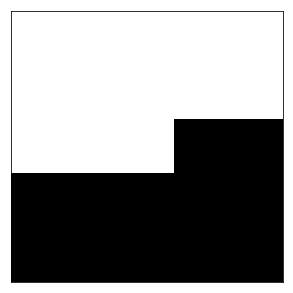

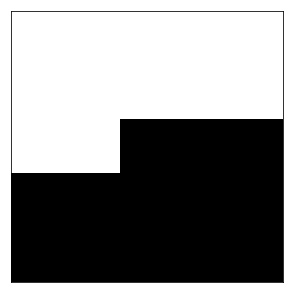

In [45]:
#  True/False로 구성된 Mask
def causal_mask(width, height, starting_point):
    row_grid, col_grid = np.meshgrid(np.arange(width), np.arange(height), indexing='ij')
#     print(row_grid)
#     print()
#     print(col_grid)
#     print('Mask making')
#     print(row_grid<starting_point[0])
#     print()
#     print(np.logical_and(row_grid == starting_point[0], col_grid <= starting_point[1]))
#     print()
#     print(np.logical_or(
#         row_grid < starting_point[0],
#         np.logical_and(row_grid == starting_point[0], col_grid <= starting_point[1])))
    mask = np.logical_or(
        row_grid < starting_point[0],
        np.logical_and(row_grid == starting_point[0], col_grid <= starting_point[1]))
    return mask

# True/False Mask를 1,0로 구성된 Mask로 단순 변환
# B 타입의 경우 include_center=True
# A 타입의 경우 include_center=False
def conv_mask(width, height, include_center=False):
    return 1.0 * causal_mask(width, height, starting_point=(width//2, height//2 + include_center - 1))

show_as_image(conv_mask(5, 5, include_center=True))
show_as_image(conv_mask(5, 5, include_center=False))

## Zero-ing all inputs weights after center point

In [4]:
out_channels, in_channels, width, height = 2, 2, 3, 3

conv_weights = 1 + np.arange(out_channels * in_channels * width * height).reshape((out_channels, in_channels, width, height))

# conv_weights에 mask를 씌우면 weights 중간을 기준으로 그 전 값들만 통과하고 나머지는 0이 된다.
masked_weights = conv_weights * conv_mask(width, height)

masked_weights

array([[[[  1.,   2.,   3.],
         [  4.,   0.,   0.],
         [  0.,   0.,   0.]],

        [[ 10.,  11.,  12.],
         [ 13.,   0.,   0.],
         [  0.,   0.,   0.]]],


       [[[ 19.,  20.,  21.],
         [ 22.,   0.,   0.],
         [  0.,   0.,   0.]],

        [[ 28.,  29.,  30.],
         [ 31.,   0.,   0.],
         [  0.,   0.,   0.]]]])

In [5]:
# 일반적인 convolutional filter(weight)으로 convolution을 하는 것이 아니고,
# Causal Mask가 적용된 filter(weight)으로 convolution을 하는 모듈을 생성
# (아래 두 그림 참고)
class MaskedConv2d(nn.Conv2d):
    def __init__(self, mask_type, *args, **kwargs):
        super(MaskedConv2d, self).__init__(*args, **kwargs)
        _, n_channels, width, height = self.weight.size()

        mask = conv_mask(width, height, include_center=mask_type=='B')
        self.register_buffer('mask', torch.from_numpy(mask).float())

    def forward(self, x):
        self.weight.data *= self.mask
        return super(MaskedConv2d, self).forward(x)

## Fully convolutional network preserving spatial resolution

Input to output map      |  Output distribution
:-------------------------:|:-------------------------:
![](https://tensorflowkorea.files.wordpress.com/2016/11/pixel-cnn1.png)  |  ![](http://tinyclouds.org/residency/pixelcnn.png)

Quite a counter-intuitive model:

 * Convolutional layers bottom to top!
 * Last layer with `kernel_size=1` and outputs $ n_W \times n_H \times n_{pixels}$ logits, inferring $p(\mathbf{x})$ in one forward pass (during training)
 * Representation of dimension `n_channels` output by each layer anologous to RNN's internal state vector $\mathbf{h}$
 * Necessary to stack enough layers (and/or dillatations) to augment the "receptive field" so that output pixels can be influenced by the whole image
 

Below is a minimalistic implementation for 0/1 pixels without many of the bells and whistles of the original paper:

In [6]:
class PixelCNN(nn.Module):
    n_channels = 4
    kernel_size = 7
    padding = 3
    n_pixels_out = 2 # binary 0/1 pixels
    
    # MaskedConv2d A - BN - ReLU - MaskedConv2d B - BN - ReLU - MaskedConv2d B - BN - ReLU - Conv2d
    def __init__(self):
        super(PixelCNN, self).__init__()
        self.layers = nn.Sequential(
            MaskedConv2d('A', in_channels=1, out_channels=self.n_channels, kernel_size=self.kernel_size, padding=self.padding, bias=False), nn.BatchNorm2d(self.n_channels), nn.ReLU(True),
            MaskedConv2d('B', self.n_channels, self.n_channels, kernel_size=self.kernel_size, padding=self.padding, bias=False), nn.BatchNorm2d(self.n_channels), nn.ReLU(True),
            MaskedConv2d('B', self.n_channels, self.n_channels, kernel_size=self.kernel_size, padding=self.padding, bias=False), nn.BatchNorm2d(self.n_channels), nn.ReLU(True),
            nn.Conv2d(in_channels=self.n_channels, out_channels=self.n_pixels_out, kernel_size=1)
        )
        
    def forward(self, x):
        pixel_logits = self.layers(x)
        return pixel_logits

## LCD 숫자 이미지를 생성하는 심플한 generative model을 만들어 보자
<br>
Application on a simple generative model of LCD digits
<br>
From https://gist.github.com/benjaminwilson/b25a321f292f98d74269b83d4ed2b9a8#file-lcd-digits-dataset-nmf-ipynb

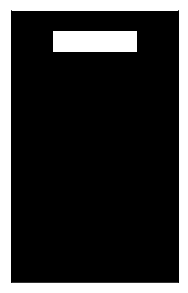

In [7]:
CELL_LENGTH = 4 # 숫자의 한 획의 길이
IMAGE_WIDTH, IMAGE_HEIGHT = 2 * CELL_LENGTH + 5, CELL_LENGTH + 4 # 획의 길이에 따른 LCD 이미지 규격

# 세로 획 그리기
def vertical_stroke(rightness, downness):
    """
    Return a 2d numpy array representing an image with a single vertical stroke in it.
    `rightness` and `downness` are values from [0, 1] and define the position of the vertical stroke.
    """
    i = (downness * (CELL_LENGTH + 1)) + 2
    j = rightness * (CELL_LENGTH + 1) + 1
    x = np.zeros(shape=(IMAGE_WIDTH, IMAGE_HEIGHT), dtype=np.float64)
    x[i + np.arange(CELL_LENGTH), j] = 1.
    return x

# 가로 획 그리기
def horizontal_stroke(downness):
    """
    Analogue to vertical_stroke, but it returns horizontal strokes.
    `downness` is here a value in [0, 1, 2].
    """
    i = (downness * (CELL_LENGTH + 1)) + 1
    x = np.zeros(shape=(IMAGE_WIDTH, IMAGE_HEIGHT), dtype=np.float64)
    x[i, 2 + np.arange(CELL_LENGTH)] = 1.
    return x

show_as_image(horizontal_stroke(0))
# show_as_image(horizontal_stroke(1))
# show_as_image(horizontal_stroke(2))
# show_as_image(vertical_stroke(0,0))
# show_as_image(vertical_stroke(0,1))
# show_as_image(vertical_stroke(1,0))
# show_as_image(vertical_stroke(1,1))

[[ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  1.  1.  1.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  1.  0.]
 [ 0.  1.  0.  0.  0.  0.  1.  0.]
 [ 0.  1.  0.  0.  0.  0.  1.  0.]
 [ 0.  1.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  1.  1.  1.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  1.  1.  1.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]]


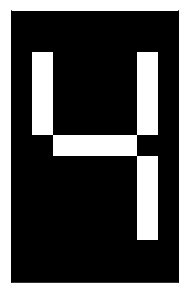

In [47]:
# 0 ~ 9 사이의 숫자를 만들 수 있는 기본 획(가로, 세로)들 총 집합.
# 가로 획 3개 + 세로 획 4개 = 총 7개 획
BASE_STROKES = np.asarray(
    [horizontal_stroke(k) for k in range(3)] + [vertical_stroke(k, l) for k in range(2) for l in range(2)])

# 기본 획들 총 집합 중에서 각 숫자를 만들기 위해 실제로 필요한 획 구성 
DIGITS_STROKES = np.array([[0, 2, 3, 4, 5, 6], [5, 6], [0, 1, 2, 4, 5], [0, 1, 2, 5, 6], [1, 3, 5, 6], [0, 1, 2, 3, 6], [0, 1, 2, 3, 4, 6], [0, 5, 6], np.arange(7), [0, 1, 2, 3, 5, 6]])

# 저 기본 획들과 각 숫자를 만들기 위한 조합을 이용해서 랜덤 숫자 이미지를 만들어 낸다.
def random_digits(strokes=BASE_STROKES, digit_as_strokes=DIGITS_STROKES, fixed_label=None):
    label = fixed_label if fixed_label is not None else np.random.choice(len(digit_as_strokes))
    combined_strokes = strokes[digit_as_strokes[label], :, :].sum(axis=0)
    return combined_strokes, label

def batch_images_to_one(batches_images):
    n_square_elements = int(np.sqrt(batches_images.shape[0]))
    rows_images = np.split(np.squeeze(batches_images), n_square_elements)
    return np.vstack([np.hstack(row_images) for row_images in rows_images])

print(random_digits()[0])
show_as_image(random_digits()[0])
# show_as_image(random_digits()[0])
# show_as_image(random_digits()[0])
# show_as_image(random_digits(fixed_label=3)[0])
# show_as_image(random_digits(fixed_label=4)[0])
# show_as_image(random_digits(fixed_label=5)[0])
# show_as_image(batch_images_to_one(np.stack([random_digits()[0] for _ in range(25)])), figsize=(9, 9))

In [48]:
from torch.utils.data import Dataset, DataLoader

# 위에서 만든, LCD Digits 만들기 함수를 이용해서 Custom Dataset을 만든다.
class LcdDigits(Dataset):

    def __init__(self, n_examples):
        digits, labels = zip(*[random_digits() for _ in range(n_examples)])
        self.digits = np.asarray(digits, dtype=np.float64)
        self.labels = np.asarray(labels)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        digit_with_channel = self.digits[idx][np.newaxis, :, :]
        
        return torch.from_numpy(digit_with_channel).float(), torch.from_numpy(np.array([self.labels[idx]]))

# next(b for b in DataLoader(LcdDigits(128), batch_size=3))

## Training

In [11]:
import torch.nn.functional as F

N_EPOCHS = 25
BATCH_SIZE = 128
LR = 0.005

cnn = PixelCNN()
optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)

train_dataset = LcdDigits(BATCH_SIZE * 50)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)

for epoch in range(N_EPOCHS):
    for i, (images, _) in enumerate(train_loader):
        images = Variable(images) # BATCH_SIZE x 1 x 13 x 8
        pixelCNN_out = cnn(images) # BATCH_SIZE x 2 x 13 x 8
        pixelCNN_target = torch.squeeze(images).long() # BATCH_SIZE x 13 x 8
        optimizer.zero_grad()
        loss = F.cross_entropy(input=pixelCNN_out, target=pixelCNN_target)
        loss.backward()
        optimizer.step()
        
        if i % 100 == 0:
            print ('Epoch [%d/%d], Loss: %.4f' 
                   %(epoch+1, N_EPOCHS, loss.data[0]))

Epoch [1/25], Loss: 0.6638
Epoch [2/25], Loss: 0.2659
Epoch [3/25], Loss: 0.0758
Epoch [4/25], Loss: 0.0421
Epoch [5/25], Loss: 0.0349
Epoch [6/25], Loss: 0.0317
Epoch [7/25], Loss: 0.0290
Epoch [8/25], Loss: 0.0268
Epoch [9/25], Loss: 0.0256
Epoch [10/25], Loss: 0.0254
Epoch [11/25], Loss: 0.0251
Epoch [12/25], Loss: 0.0252
Epoch [13/25], Loss: 0.0257
Epoch [14/25], Loss: 0.0257
Epoch [15/25], Loss: 0.0255
Epoch [16/25], Loss: 0.0250
Epoch [17/25], Loss: 0.0248
Epoch [18/25], Loss: 0.0246
Epoch [19/25], Loss: 0.0241
Epoch [20/25], Loss: 0.0239
Epoch [21/25], Loss: 0.0242
Epoch [22/25], Loss: 0.0239
Epoch [23/25], Loss: 0.0241
Epoch [24/25], Loss: 0.0237
Epoch [25/25], Loss: 0.0238


## input 이미지를 pixel-by-pixel 흝고 지나가면서 이미지 생성해보기
<br>
Sequentially generating new samples 

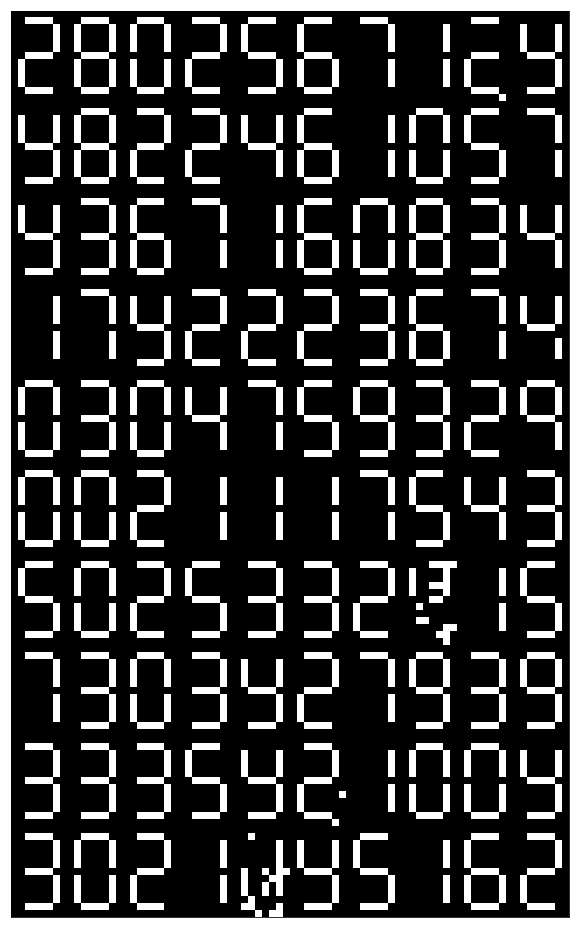

In [12]:
# pixelCNN로 새로운 샘플 만들기
# 어떤 특정한 이미지를 pixelCNN의 input으로 줄 수도 있고 아니면 그냥 zeros를 넣어 줄 수도 있다.
# pixelCNN은 input으로 주어진 이미지를 Masked Convolution으로 흝고 지나가면서 자신의 기억속에 존재하는, 가장 그럴듯한 픽셀 값을 예측해 낸다.
def generate_samples(n_samples, starting_point=(0, 0), starting_image=None):
    samples = torch.from_numpy(
        starting_image if starting_image is not None else np.zeros((n_samples * n_samples, 1, IMAGE_WIDTH, IMAGE_HEIGHT))).float()

    cnn.train(False)

    # pixelCNN이 예측한 pixel-level distribution으로 부터 픽셀 값(0 또는 1)을 샘플링해서 이미지를 만들어 낸다.
    for i in range(IMAGE_WIDTH):
        for j in range(IMAGE_HEIGHT):
            if i < starting_point[0] or (i == starting_point[0] and j < starting_point[1]):
                continue
            out = cnn(Variable(samples, volatile=True))
            probs = F.softmax(out[:, :, i, j]).data
            samples[:, :, i, j] = torch.multinomial(probs, 1).float()
    return samples.numpy()

show_as_image(batch_images_to_one(generate_samples(n_samples=10)), figsize=(10, 20))

## 이미지의 일부분을 input으로 주고, 나머지 부분을 완성하기
<br>
Or completing existing cropped image

 * $0, 8, 9$ and $2, 3, 7$ undistinguishable early one
 * Very small amount of noise (jitter) in samples
 * The last horizontal bar is hard to predict as it depends on the 1st horizontal bar
 * ($4, 9$) sometimes lead to incomplete or erroneous images because of the long term dependency between the upper and lower horizontal bars (could be improved by increasing the receptive field with more layers or "à trous" convolutions)

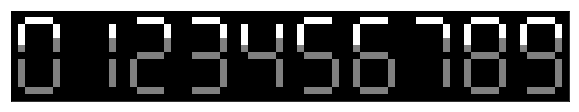

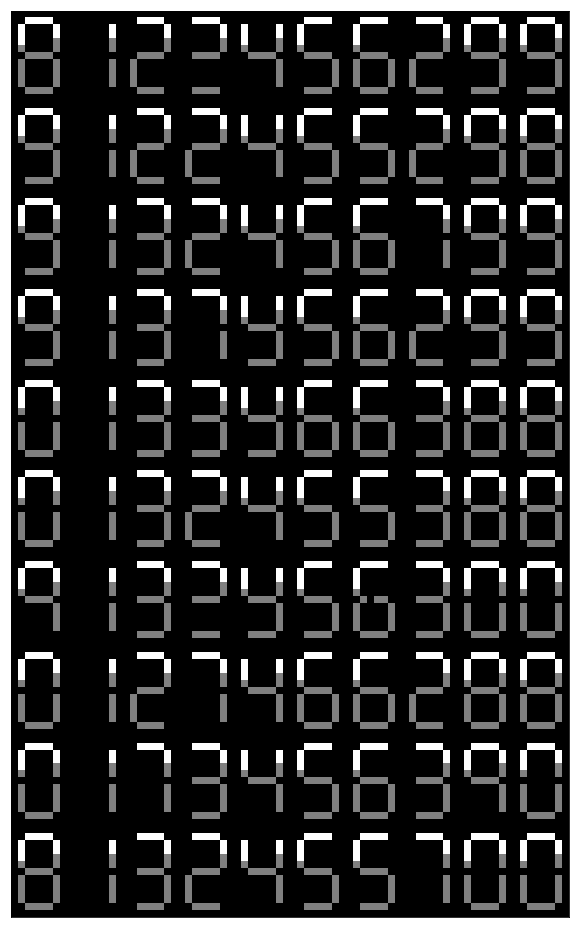

In [13]:
n_images = 10
starting_point = (4, 3)

mask = causal_mask(IMAGE_WIDTH, IMAGE_HEIGHT, starting_point)

starting_images = digits_list = [random_digits(fixed_label=d)[0] for d in range(10)]
batch_starting_images = np.expand_dims(np.stack([i * mask for i in starting_images] * n_images), axis=1)

samples = generate_samples(n_images, starting_image=batch_starting_images, starting_point=starting_point)

show_as_image(np.hstack([(1 + mask) * i for i in starting_images]), figsize=(10, 10))

show_as_image(
    batch_images_to_one((samples * (1 + mask))),
    figsize=(10, 20))